In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
import os


In [3]:
SEQ_LEN = 168    
PRED_LEN = 48    
BATCH_SIZE = 64
EPOCHS = 70
SAVE_MODEL_PATH = "cnn_lstm_multi_outputs.h5"

In [4]:
df = pd.read_csv("/mnt/e/pbl7/datatrainai_filled.csv")
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["date", "hour"]).reset_index(drop=True)

In [5]:
FEATURES = ["T2M","QV2M","PS","WS10M","PRECTOTCORR","CLRSKY_SFC_SW_DWN",
             "Latitude","Longitude","hour","day","month"]
TARGETS  = ["T2M","QV2M","PS","WS10M","PRECTOTCORR","CLRSKY_SFC_SW_DWN"]

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(df[FEATURES])
y_scaled = scaler_y.fit_transform(df[TARGETS])

train_size = int(len(df) * 0.8)
X_train, X_val = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_val = y_scaled[:train_size], y_scaled[train_size:]

def sequence_generator(X, y, seq_len, pred_len):
    total_len = len(X)
    for i in range(total_len - seq_len - pred_len):
        x_seq = X[i:i+seq_len]
        y_seq = y[i+seq_len:i+seq_len+pred_len]  # (pred_len, n_outputs)
        yield x_seq.astype(np.float32), y_seq.astype(np.float32)

def make_tf_dataset(X, y, seq_len, pred_len, batch_size, shuffle=False):
    output_signature = (
        tf.TensorSpec(shape=(seq_len, X.shape[1]), dtype=tf.float32),
        tf.TensorSpec(shape=(pred_len, y.shape[1]), dtype=tf.float32)
    )
    ds = tf.data.Dataset.from_generator(
        lambda: sequence_generator(X, y, seq_len, pred_len),
        output_signature=output_signature
    )
    if shuffle:
        ds = ds.shuffle(2000)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_tf_dataset(X_train, y_train, SEQ_LEN, PRED_LEN, BATCH_SIZE, shuffle=True)
val_ds   = make_tf_dataset(X_val, y_val, SEQ_LEN, PRED_LEN, BATCH_SIZE)

I0000 00:00:1760786455.489771    1274 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2246 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


In [6]:
os.makedirs("saved_scaler", exist_ok=True)

with open("saved_scaler/scaler_X.pkl", "wb") as f:
    pickle.dump(scaler_X, f)

with open("saved_scaler/scaler_y.pkl", "wb") as f:
    pickle.dump(scaler_y, f)

print("lưu trong thư mục /saved_scaler/")


lưu trong thư mục /saved_scaler/


In [7]:
model = models.Sequential([
    layers.Conv1D(64, 3, activation='relu', input_shape=(SEQ_LEN, len(FEATURES))),
    layers.Conv1D(64, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.LSTM(128, return_sequences=False),
    layers.Dense(128, activation='relu'),
    layers.Dense(PRED_LEN * len(TARGETS)),  # output nhiều giá trị
    layers.Reshape((PRED_LEN, len(TARGETS))) # (24, số đặc trưng dự báo)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# ==== HUẤN LUYỆN ====
callbacks = [
    EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True, verbose=1),
    ModelCheckpoint("best_cnn_lstm_multi_outputs.h5", monitor="val_loss", save_best_only=True, verbose=1)
]

history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)

model.save(SAVE_MODEL_PATH)
print("✅ Model saved:", SAVE_MODEL_PATH)

/home/phangiabo-1170/ml/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 166, 64)        │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 164, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 82, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 288)            │        37,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 48, 6)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,008 (652.38 KB)

 Trainable params: 167,008 (652.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70


2025-10-18 18:20:58.803428: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400


  21190/Unknown 493s 23ms/step - loss: 0.0039 - mae: 0.0320

2025-10-18 18:29:09.114481: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-10-18 18:29:09.114543: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_8]]
2025-10-18 18:29:09.114560: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5327380495118912363
2025-10-18 18:29:09.114565: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7091217730786948479
2025-10-18 18:29:09.114570: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15533165866374506784
2025-10-18 18:29:09.114573: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7729419880589507740
/home/phan


Epoch 1: val_loss improved from None to nan, saving model to best_cnn_lstm_multi_outputs.h5


2025-10-18 18:30:41.745338: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-10-18 18:30:41.745387: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7549897588202406607
2025-10-18 18:30:41.745394: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15751369534578547814
2025-10-18 18:30:41.745398: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9649930428729442208


21190/21190 ━━━━━━━━━━━━━━━━━━━━ 585s 27ms/step - loss: 0.0015 - mae: 0.0225 - val_loss: nan - val_mae: nan
Epoch 2/70
21188/21190 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.8058e-04 - mae: 0.0161

2025-10-18 18:38:21.550231: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5327380495118912363
2025-10-18 18:38:21.550287: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7091217730786948479
2025-10-18 18:38:21.550298: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15533165866374506784
2025-10-18 18:38:21.550305: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7729419880589507740



Epoch 2: val_loss did not improve from nan
21190/21190 ━━━━━━━━━━━━━━━━━━━━ 552s 26ms/step - loss: 4.9223e-04 - mae: 0.0149 - val_loss: nan - val_mae: nan
Epoch 3/70


2025-10-18 18:39:53.622894: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-10-18 18:39:53.622937: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15751369534578547814
2025-10-18 18:39:53.622943: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9649930428729442208


21190/21190 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.2961e-04 - mae: 0.0139

2025-10-18 18:47:38.855335: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5327380495118912363
2025-10-18 18:47:38.855371: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7091217730786948479
2025-10-18 18:47:38.855414: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15533165866374506784
2025-10-18 18:47:38.855420: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7729419880589507740



Epoch 3: val_loss did not improve from nan
21190/21190 ━━━━━━━━━━━━━━━━━━━━ 557s 26ms/step - loss: 3.9562e-04 - mae: 0.0134 - val_loss: nan - val_mae: nan
Epoch 4/70


2025-10-18 18:49:10.229141: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15751369534578547814
2025-10-18 18:49:10.229178: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9649930428729442208


21189/21190 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.8702e-04 - mae: 0.0132

2025-10-18 18:56:58.263360: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15533165866374506784
2025-10-18 18:56:58.263402: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7729419880589507740



Epoch 4: val_loss did not improve from nan
21190/21190 ━━━━━━━━━━━━━━━━━━━━ 561s 26ms/step - loss: 3.5928e-04 - mae: 0.0127 - val_loss: nan - val_mae: nan
Epoch 5/70


2025-10-18 18:58:30.911403: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-10-18 18:58:30.911437: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7549897588202406607
2025-10-18 18:58:30.911444: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15751369534578547814
2025-10-18 18:58:30.911447: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9649930428729442208


21190/21190 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.6286e-04 - mae: 0.0128

2025-10-18 19:06:17.533417: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5327380495118912363
2025-10-18 19:06:17.533454: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7091217730786948479
2025-10-18 19:06:17.533472: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15533165866374506784
2025-10-18 19:06:17.533477: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7729419880589507740



Epoch 5: val_loss did not improve from nan
21190/21190 ━━━━━━━━━━━━━━━━━━━━ 558s 26ms/step - loss: 3.3839e-04 - mae: 0.0123 - val_loss: nan - val_mae: nan
Epoch 6/70


2025-10-18 19:07:48.844812: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9649930428729442208


21190/21190 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.4708e-04 - mae: 0.0125

2025-10-18 19:15:36.400380: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7729419880589507740



Epoch 6: val_loss did not improve from nan
21190/21190 ━━━━━━━━━━━━━━━━━━━━ 559s 26ms/step - loss: 3.2429e-04 - mae: 0.0121 - val_loss: nan - val_mae: nan
Epoch 7/70


2025-10-18 19:17:08.183445: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9649930428729442208


21188/21190 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.3636e-04 - mae: 0.0123

2025-10-18 19:24:56.824094: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5327380495118912363
2025-10-18 19:24:56.824131: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7091217730786948479
2025-10-18 19:24:56.824138: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15533165866374506784
2025-10-18 19:24:56.824142: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7729419880589507740



Epoch 7: val_loss did not improve from nan
21190/21190 ━━━━━━━━━━━━━━━━━━━━ 562s 26ms/step - loss: 3.1489e-04 - mae: 0.0119 - val_loss: nan - val_mae: nan
Epoch 8/70


2025-10-18 19:26:29.802348: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9649930428729442208


21189/21190 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.2892e-04 - mae: 0.0121

2025-10-18 19:34:20.687956: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5327380495118912363
2025-10-18 19:34:20.687994: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7091217730786948479
2025-10-18 19:34:20.688001: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15533165866374506784
2025-10-18 19:34:20.688005: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7729419880589507740



Epoch 8: val_loss did not improve from nan
21190/21190 ━━━━━━━━━━━━━━━━━━━━ 562s 26ms/step - loss: 3.0751e-04 - mae: 0.0117 - val_loss: nan - val_mae: nan
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 1.


2025-10-18 19:35:51.681507: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-10-18 19:35:51.681549: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7549897588202406607
2025-10-18 19:35:51.681557: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15751369534578547814
2025-10-18 19:35:51.681562: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9649930428729442208


✅ Model saved: cnn_lstm_multi_outputs.h5


In [8]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))



[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


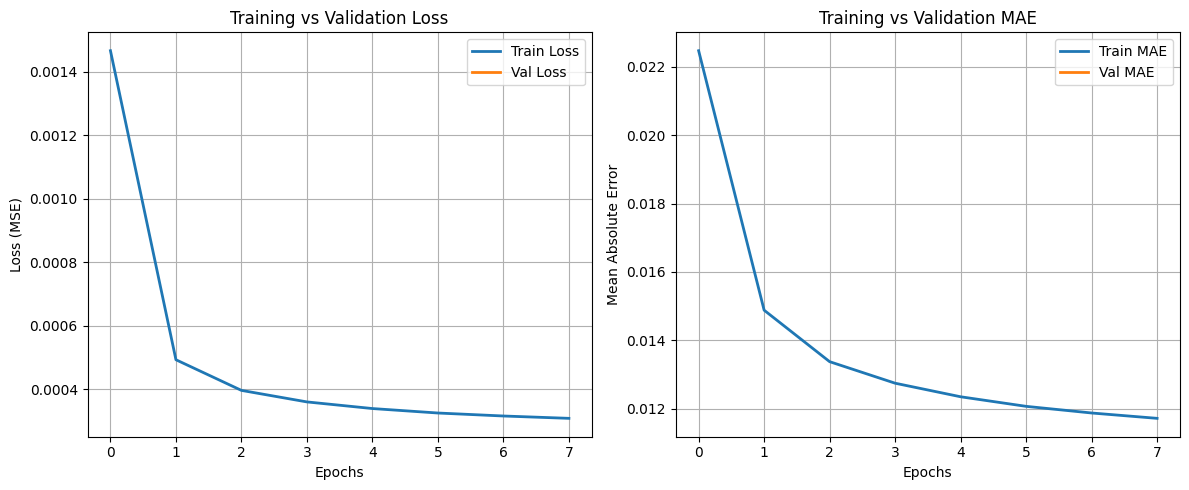

In [9]:
# === VẼ ĐỒ THỊ HUẤN LUYỆN ===
plt.figure(figsize=(12, 5))

# Đồ thị Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

# Đồ thị MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE', linewidth=2)
plt.plot(history.history['val_mae'], label='Val MAE', linewidth=2)
plt.title('Training vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


/tmp/ipykernel_1274/890203362.py:31: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/home/phangiabo-1170/ml/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


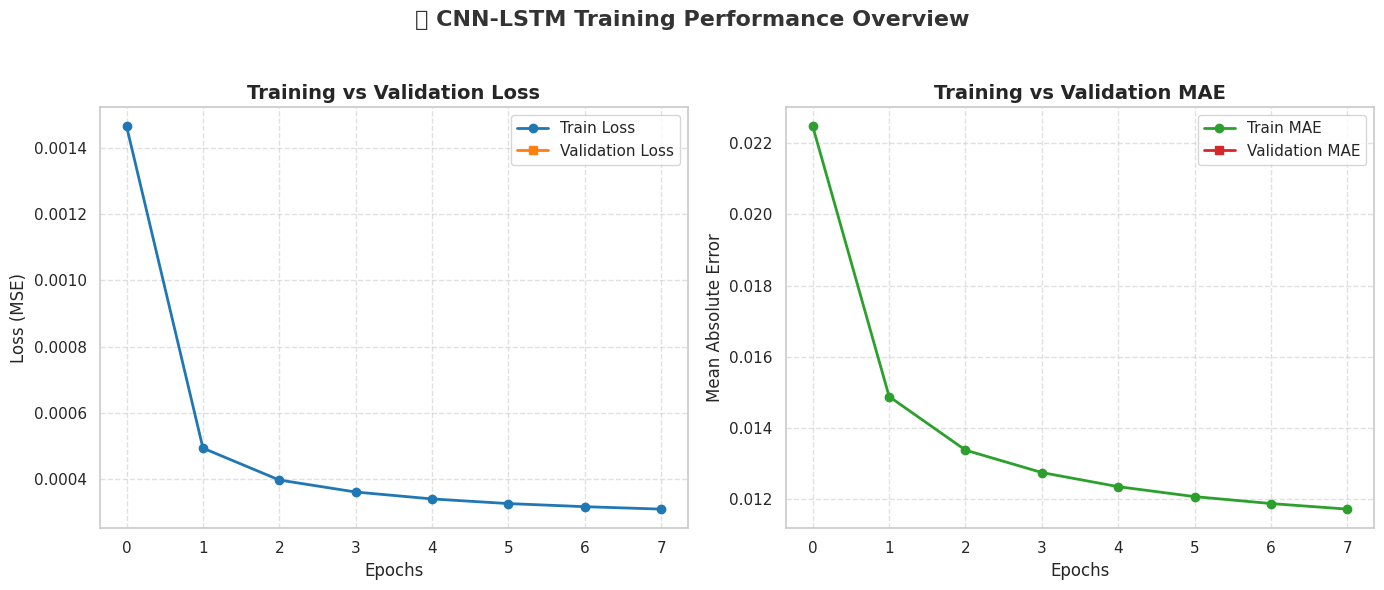

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Kích hoạt style đẹp hơn
sns.set(style="whitegrid")

# Tạo figure
plt.figure(figsize=(14, 6))

# === ĐỒ THỊ 1: LOSS ===
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], color='#1f77b4', marker='o', linewidth=2, label='Train Loss')
plt.plot(history.history['val_loss'], color='#ff7f0e', marker='s', linewidth=2, label='Validation Loss')
plt.title('Training vs Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# === ĐỒ THỊ 2: MAE ===
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], color='#2ca02c', marker='o', linewidth=2, label='Train MAE')
plt.plot(history.history['val_mae'], color='#d62728', marker='s', linewidth=2, label='Validation MAE')
plt.title('Training vs Validation MAE', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Mean Absolute Error', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.suptitle('📈 CNN-LSTM Training Performance Overview', fontsize=16, fontweight='bold', color='#333')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



In [13]:
print(history.history.keys())
print("val_loss:", history.history['val_loss'])
print("val_mae:", history.history['val_mae'])


dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])
val_loss: [nan, nan, nan, nan, nan, nan, nan, nan]
val_mae: [nan, nan, nan, nan, nan, nan, nan, nan]
